# CS 497/597: Tensorflow With Mobilenet V2

## Purpose of the assignment:

To familiarize ourselves with Tensorflow and MobileNet V2 by training, tuning, and explaining how MobileNet V2 works by training it on both CIFAR100 and a dataset of our choosing.

### Step 1: Data Preprocessing

In [18]:
# Import tensorflow and keras for deep learning
import tensorflow as tf
from tensorflow import keras

# Import matplotlib to graph results
import matplotlib.pyplot as plt

#Import numpy to store imported images
import numpy as np

In [19]:
#Suppress tensorflow warnings
tf.get_logger().setLevel('WARNING')

In [20]:
# Import the training and test data for CIFAR100 and load
# the fine grained class labels so we can use all 100 classes

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data(label_mode='fine')

In [21]:
# Upscale the CIFAR100 x_train and x_test images from 32 x 32 to 80 x 80
# to upscale features for MobileNet V2 (which was trained on images with 224 x 224 pixels from the ImageNet dataset)
x_train = tf.cast(tf.image.resize(tf.convert_to_tensor(x_train), size=[96,96], method=tf.image.ResizeMethod.BICUBIC),dtype=tf.int32)
x_test = tf.cast(tf.image.resize(tf.convert_to_tensor(x_test), size=[96,96], method=tf.image.ResizeMethod.BICUBIC),dtype=tf.int32)

In [22]:
# Print the shape of the training and testing images and labels
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 96, 96, 3)
(50000, 1)
(10000, 96, 96, 3)
(10000, 1)


Note: CIFAR100 contains 60,000 images total with 100 classes. Each image is size 32 x 32 with RGB values for a total of 32 x 32 x 3 size per image. This means that each image is somewhat small in size, with only 1024 pixels and 3072 values total including RGB pixel values. The dataset loaded here is split into 50K training images and 10K test images (80% training and 20% testing).

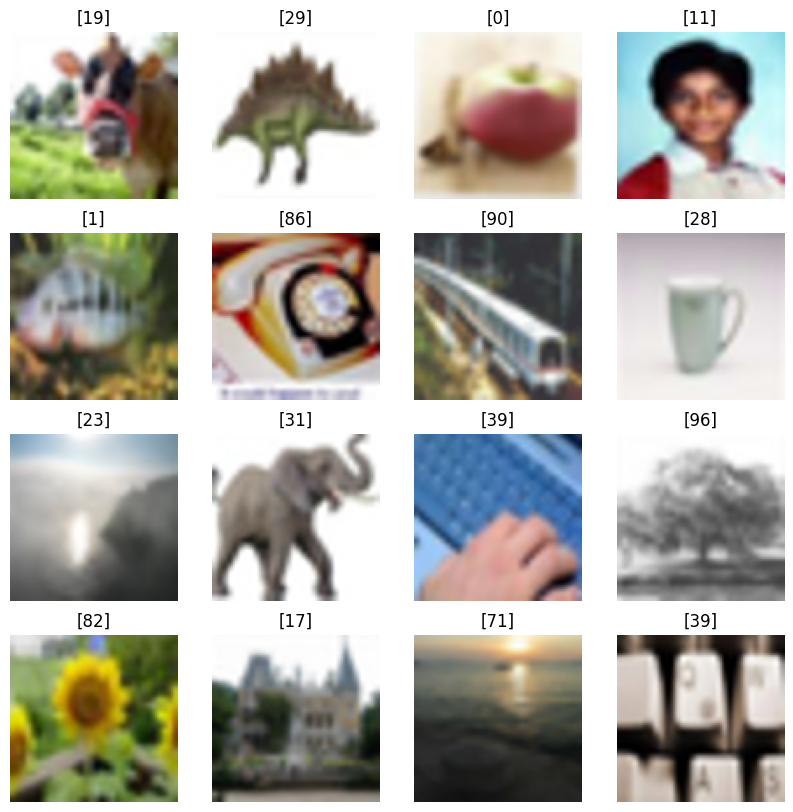

In [23]:
# Show 16 example images from the CIFAR100 dataset
plt.figure(figsize=(10,10))

for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(x_train[i])
    plt.title(y_train[i])
    plt.axis("off")

Looking at the first 16 images in the training dataset, it is clear that 1024 pixels doesn't leave room for a lot of detail. Most of the images are blurry with little space for even large patterns. The image at the bottom right appears to be a keyboard, but the image is so small that it is impossible to read what keys are displayed in the image. The image in the bottom left is an image with 3 sunflowers, but it is so pixelated that it is difficult to see how many flower petals each sunflower has. This lack of detail could either help a CNN focus on key features of an image or hurt a CNN by blurring important features that can help it distinguish between classes. We cannot know for sure whether this improves or harms MobileNet's performance until it is tested.

In [24]:
# Split the test dataset into testing and validation datasets for tuning and testing MobileNetVs2

division_point = int(x_test.shape[0]/2)
x_validation, y_validation = x_test[0:division_point], y_test[0:division_point]
X_test, Y_test = x_test[division_point:x_test.shape[0]], y_test[division_point:x_test.shape[0]]

In [25]:
# Run data augmentation to randomize incoming images and prevent overfitting with CIFAR100
data_augmentation = keras.Sequential([
  keras.layers.RandomFlip('horizontal'),
  keras.layers.RandomRotation(0.2),
])

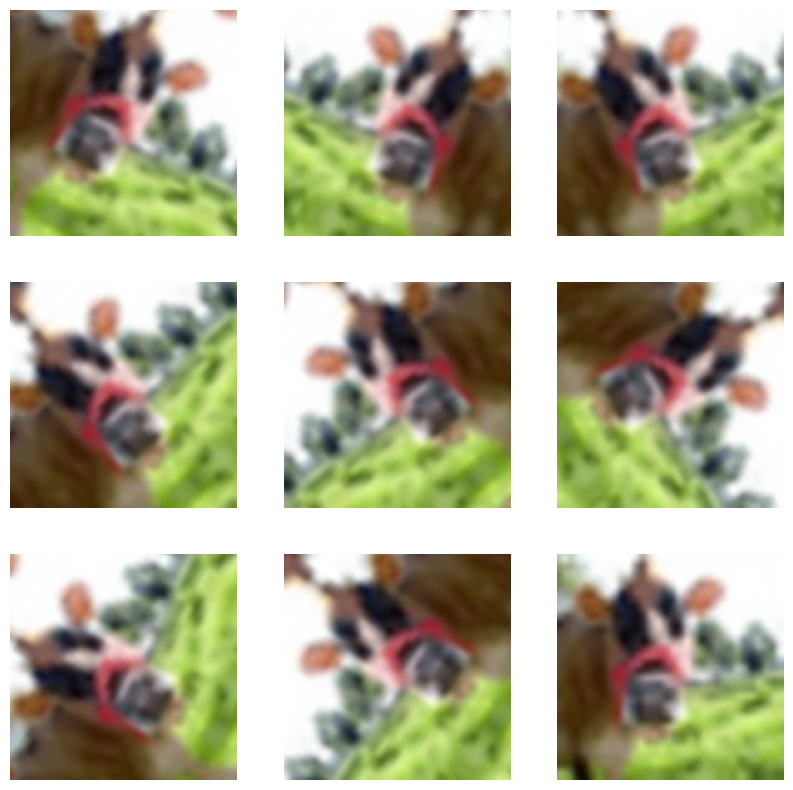

In [26]:
# Show example images from the random horizontal flip and rotation
# augmentation pipeline
data_preprocessing = keras.Sequential([
  keras.layers.Input(shape=x_train[0].shape),
  keras.layers.RandomFlip('horizontal'),
  keras.layers.RandomRotation(0.2),
])
plt.figure(figsize=(10, 10))
images = x_train[0:1]
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)

  augmented_image = data_preprocessing(images)
  plt.imshow(tf.cast(augmented_image[0], dtype=tf.int32))
  plt.axis('off')

In [27]:
# Normalize the test, train, and validation image pixels to be in the range of 0 to 1
# to prevent outliers from degrading MobileNet's accuracy
X_test = tf.cast(X_test, tf.float32) / 255.0
x_train = tf.cast(x_train, tf.float32) / 255.0
x_validation = tf.cast(x_validation, tf.float32) / 255.0

In [28]:
# Set a global batch size for the training, validation, and testing datasets for standardization
global_batch_size = 64

# Create training, validation, and testing data loaders from CIFAR100's training, validation, and testing splits
training_dataset = tf.data.Dataset.from_tensor_slices((x_train, keras.utils.to_categorical(y_train))).batch(batch_size=global_batch_size)
validation_dataset = tf.data.Dataset.from_tensor_slices((x_validation, keras.utils.to_categorical(y_validation))).batch(batch_size=global_batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, keras.utils.to_categorical(Y_test))).batch(batch_size=global_batch_size)

### Step 2: Model Construction

In [29]:
# Construct a model built on top of MobileNetV2 with an
# input layer that takes in an image of the dimensions specified
# in x_data, sends said image into mobilenet, and then takes the
# output from mobilenet into a simple classifiation head that
# predicts what label said image is from a range of labels.
# This function will return the constructed (but not compiled)
# mobilenet V2 model
def build_mobilenet_model(x_data, y_data):

    # Prepare base MobileNet V2 model
    global base_mobilenet







    # EXCLUDED IMAGENET WEIGHTS AND TOP AND MADE BASE_MOBILENET TRAINABLE - CJK

    base_mobilenet = tf.keras.applications.MobileNetV2(input_shape=x_train[0].shape, include_top=False)
    base_mobilenet.trainable = True







    # Get the prediction size of the data
    prediction_size = len(set(y_data.flatten()))

    # Create an intermediate dense layer between the average pooling layer and final prediction layer









    # TOOK OUT THIS HIDDEN OUTPUT LAYER - CJK

    # hidden_output_layer = keras.layers.Dense(200, activation='leaky_relu')








    # Create a prediction layer for each class in the CIFAR100 dataset
    prediction_layer = keras.layers.Dense(prediction_size, activation='softmax')

    # Create an input layer for the image itself
    input = tf.keras.Input(shape=x_data[0].shape)
    # Apply data augmentation pipeline





    # REMOVED DATA AUGMENTATION LAYER - CJK

    # x = data_augmentation(input)






    # Run the augmented image through MobileNet and train it




    # INPUT DATA DIRECTLY INTO MOBILENET

    x = base_mobilenet(input)






    # apply dropout to prevent overfitting
    # Average pooling layer
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dropout(0.1)(x)
    # apply a hidden dense layer between the last MobileNet layer and prediction layer








    # REMOVED THIS HIDDEN OUTPUT LAYER - CJK

    # x = hidden_output_layer(x)








    # Get the final prediction of the model with a single fully connected layer
    output = prediction_layer(x)
    # Construct the model and pipeline
    model = keras.Model(input, output)

    # return constructed model
    return model

In [30]:
# Construct model based on MobileNetV2 that is adapted to the input size of
#CIFAR100's images and adds a classification head that takes MobileNet's output
# and turns it into a CIFAR100 prediction
model = build_mobilenet_model(x_train, y_train)

In [31]:
#3 Show the fully constructed model's parameter count and memory footprint including the base MobileNet V2 model
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_96 (Functional)     │ (None, 3, 3, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 11520)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 11520)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │       1,152,100 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,410,084 (13.01 MB)

 Trainable params: 3,375,972 (12.88 MB)

 Non-trainable params: 34,112 (133.25 KB)

### Step 3: Train Extended MobileNetV2 Model on CIFAR100 Dataset

In [32]:
# Set the learning rate, optimizer, loss function, and evaluation metrics for the model










# INCREASED YOUR BASE LEARNING RATE (THIS IS USUALLY THE TYPICAL STARTING VALUE) - CJK

base_learning_rate = 1e-3

model.compile(optimizer=keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=[keras.metrics.CategoricalAccuracy(name="accuracy"),
                       keras.metrics.Recall(name="recall"),
                       keras.metrics.Precision(name="precision"),
                       keras.metrics.F1Score(name="f1_score", average="weighted")])

In [33]:
# Train MobileNet for 10 epochs total with the CIFAR100 training images
# and use the validation dataset to evaluate MobileNet's training progress
# after each epoch with accuracy, precision, recall, and f1_score. The early stopping
# callback prevents the current model from being trained if the validation
# accuracy no longer improves by much.











# INCREASED THE NUMBER OF TRAINING EPOCHS, ADDED CALLBACKS, AND MONITORED VALIDATION LOSS INSTEAD OF VALIDATION ACCURACY - CJK

training_epochs = 30

early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, verbose=1)
reduce_lr_loss = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, verbose=1, min_delta=1e-4)

callbacks = [early_stopping, reduce_lr_loss]

history = model.fit(training_dataset,
                    epochs=training_epochs,
                    validation_data=validation_dataset,
                    callbacks=callbacks)

Epoch 1/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 95s 57ms/step - accuracy: 0.3885 - f1_score: 0.3857 - loss: 2.6757 - precision: 0.5681 - recall: 0.2713 - val_accuracy: 0.0112 - val_f1_score: 0.0025 - val_loss: 15.3257 - val_precision: 0.0109 - val_recall: 0.0106 - learning_rate: 0.0010
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.6171 - f1_score: 0.6157 - loss: 1.3813 - precision: 0.7542 - recall: 0.5097 - val_accuracy: 0.0734 - val_f1_score: 0.0395 - val_loss: 10.9922 - val_precision: 0.1101 - val_recall: 0.0634 - learning_rate: 0.0010
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.6861 - f1_score: 0.6855 - loss: 1.0709 - precision: 0.7982 - recall: 0.6024 - val_accuracy: 0.1228 - val_f1_score: 0.1003 - val_loss: 8.7631 - val_precision: 0.1411 - val_recall: 0.1096 - learning_rate: 0.0010
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.7318 - f1_score: 0.7311 - loss: 0.8864 - precision: 0.8206 - recall: 0.6616 - val_accuracy: 0.12

In [34]:
# Save the trained model weights for the extended MobileNetV2 model





# TOOK THIS OUT SO IT WILL WORK WHEN OMIYA RUNS THE CODE ON HER MACHINE - CJK

# model.save_weights(filepath="checkpoints/train/MobileNetV2_CIFAR100.weights.h5", overwrite=True)

In [35]:
def graph_accuracy_loss(history, total_epochs, fine_tune_history=None, initial_epochs=None):
    # Plot the validation and training accuracy and loss of MobileNetV2 across all training epochs
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    # Extract all of the metric history for plotting and add fine tuning history if it exists
    if fine_tune_history is not None:
        acc += fine_tune_history.history["accuracy"]
        val_acc += fine_tune_history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    if fine_tune_history is not None:
        loss += fine_tune_history.history["loss"]
        val_loss += fine_tune_history.history['val_loss']

    precision = history.history['precision']
    val_precision = history.history['val_precision']

    if fine_tune_history is not None:
        precision += fine_tune_history.history["precision"]
        val_precision += fine_tune_history.history['val_precision']

    recall = history.history['recall']
    val_recall = history.history['val_recall']

    if fine_tune_history is not None:
        recall += fine_tune_history.history["recall"]
        val_recall += fine_tune_history.history['val_recall']

    f1_score = history.history['f1_score']
    val_f1_score = history.history['val_f1_score']

    if fine_tune_history is not None:
        f1_score += fine_tune_history.history["f1_score"]
        val_f1_score += fine_tune_history.history['val_f1_score']

    # Plot the training and validation accuracies for CIFAR100
    fig, ax = plt.subplots(nrows=5, ncols=1)
    fig.set_figwidth(10)
    fig.set_figheight(25)
    #plt.subplot(1, 1, 1)
    plt.xticks(range(0, total_epochs, 1))
    plt.ylim((0,1))

    ax[0].plot(acc, label='Training Accuracy')
    ax[0].plot(val_acc, label='Validation Accuracy')
    if fine_tune_history is not None:
        ax[0].plot([initial_epochs-1, initial_epochs-1],
                   plt.ylim(), label='Start Fine Tuning')
    ax[0].legend(loc='lower right')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_ylim([min(plt.ylim()),1])
    ax[0].set_xlabel('epoch')
    ax[0].set_title('Training and Validation Accuracy For MobileNet V2 on CIFAR100 Dataset')

    #Plot the training and validation losses for CIFAR100
    #plt.subplot(2, 1, 2)
    ax[1].plot(loss, label='Training Loss')
    ax[1].plot(val_loss, label='Validation Loss')
    if fine_tune_history is not None:
        ax[1].plot([initial_epochs-1, initial_epochs-1],
                    ax[1].get_ylim(), label='Start Fine Tuning')
    ax[1].legend(loc='upper right')
    ax[1].set_ylabel('Cross Entropy')
    ax[1].set_title('Training and Validation Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_xticks(range(0, total_epochs, 1))

    #Plot the training and validation precision for CIFAR100
    #plt.subplot(1, 2, 1)
    ax[2].plot(precision, label='Training Precision')
    ax[2].plot(val_precision, label='Validation Precision')
    if fine_tune_history is not None:
        ax[2].plot([initial_epochs-1, initial_epochs-1],
                    plt.ylim(), label='Start Fine Tuning')
    ax[2].legend(loc='upper right')
    ax[2].set_ylabel('Precision')
    ax[2].set_title('Training and Validation Precision')
    ax[2].set_xlabel('epoch')
    ax[2].set_xticks(range(0, total_epochs, 1))

    #Plot the training and validation recall for CIFAR100
    ax[3].plot(recall, label='Training Recall')
    ax[3].plot(val_recall, label='Validation Recall')
    if fine_tune_history is not None:
        ax[3].plot([initial_epochs-1, initial_epochs-1],
                    plt.ylim(), label='Start Fine Tuning')
    ax[3].legend(loc='upper right')
    ax[3].set_ylabel('Recall')
    ax[3].set_title('Training and Validation Recall')
    ax[3].set_xlabel('epoch')
    ax[3].set_xticks(range(0, total_epochs, 1))

    #Plot the training and validation f1 score for CIFAR100
    ax[4].plot(f1_score, label='Training F1 Score')
    ax[4].plot(val_f1_score, label='Validation F1 Score')
    if fine_tune_history is not None:
        ax[4].plot([initial_epochs-1, initial_epochs-1],
                    plt.ylim(), label='Start Fine Tuning')
    ax[4].legend(loc='upper right')
    ax[4].set_ylabel('F1 Score')
    ax[4].set_title('Training and Validation F1 Score')
    ax[4].set_xlabel('epoch')
    ax[4].set_xticks(range(0, total_epochs, 1))

    # Show both the training and validation accuracies
    plt.show()

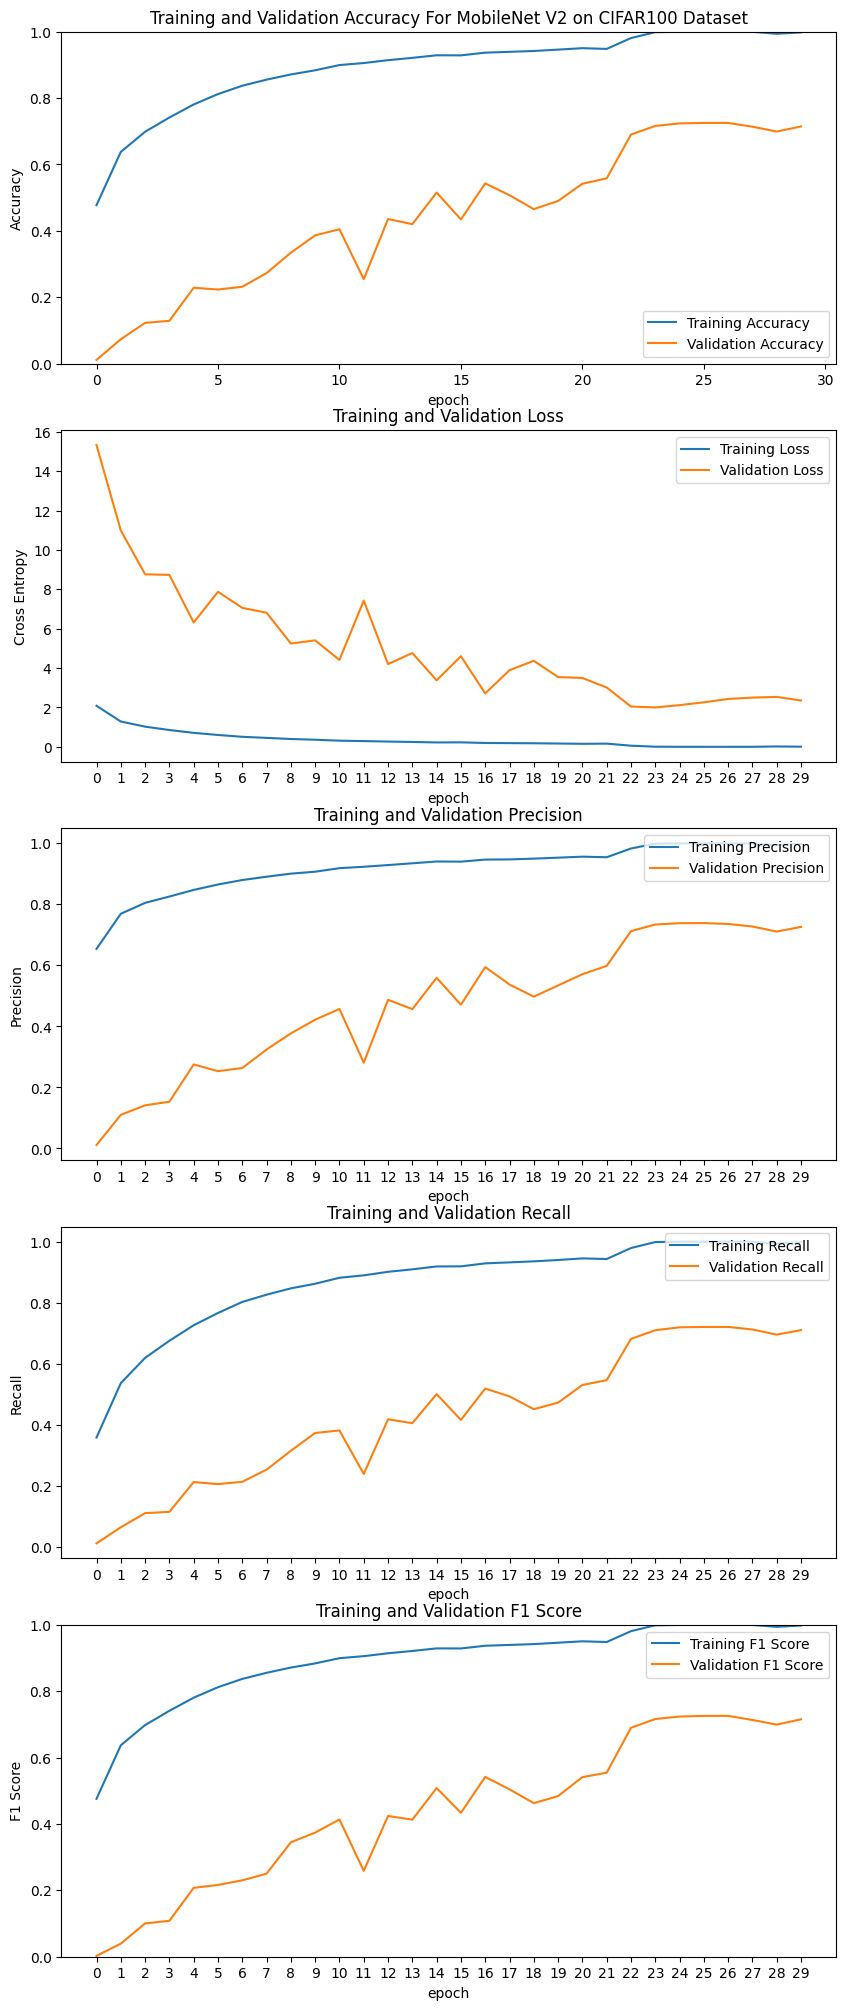

In [36]:
# Plot the validation and training accuracy and loss of MobileNetV2 across all training epochs
graph_accuracy_loss(history=history, total_epochs=training_epochs, fine_tune_history=None)

### Step 4: Fine Tuning For MobileNet V2

In [37]:
# Set the entire model to be trainable
base_mobilenet.trainable = True

# Print the number of layers inside the mobilenet V2 model
print("The total number of layers in the MobileNetV2 model is " + str(len(base_mobilenet.layers)) + " layers")

# any layer below this layer will remain frozen during fine tuning
fine_tune_threshold = 100

# Freeze all layers in MobileNet below the layers we want to train
for layer in base_mobilenet.layers[:fine_tune_threshold]:
    layer.trainable = False

The total number of layers in the MobileNetV2 model is 154 layers


In [38]:
#Compile the model that will be fine tuned with a lower learning rate
#And different optimizer to prevent overfitting
model.compile(loss=keras.losses.CategoricalCrossentropy(),
              optimizer=keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[keras.metrics.CategoricalAccuracy(name="accuracy"),
                       keras.metrics.Recall(name="recall"),
                       keras.metrics.Precision(name="precision"),
                       keras.metrics.F1Score(name="f1_score", average="weighted")])

In [39]:
# Add the fine tuning epochs to the training epochs
fine_tune_epochs = 10
total_epochs = training_epochs + fine_tune_epochs

In [40]:
# Fine tune both the MobileNet V2 base model and the current model
# Using the CIFAR100 training images for training and the validation
# images for evaluating training after each epoch. The early stopping
# callback prevents the current model from being trained if the validation
# accuracy no longer improves by much.
fine_tune_history = model.fit(training_dataset,
                              epochs=total_epochs,
                              initial_epoch=len(history.epoch),
                              validation_data=validation_dataset,
                              callbacks=[keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5)])

Epoch 31/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 36s 26ms/step - accuracy: 0.9995 - f1_score: 0.9995 - loss: 0.0029 - precision: 0.9995 - recall: 0.9995 - val_accuracy: 0.7158 - val_f1_score: 0.7164 - val_loss: 2.3948 - val_precision: 0.7287 - val_recall: 0.7114
Epoch 32/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.9999 - f1_score: 0.9999 - loss: 0.0013 - precision: 1.0000 - recall: 0.9999 - val_accuracy: 0.7180 - val_f1_score: 0.7184 - val_loss: 2.4467 - val_precision: 0.7281 - val_recall: 0.7146
Epoch 33/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 1.0000 - f1_score: 1.0000 - loss: 6.6520e-04 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.7180 - val_f1_score: 0.7185 - val_loss: 2.5087 - val_precision: 0.7277 - val_recall: 0.7146
Epoch 34/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 1.0000 - f1_score: 1.0000 - loss: 4.6072e-04 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.7194 - val_f1_score: 0.7198 - val_loss: 2.5553 - val_precision: 0.7

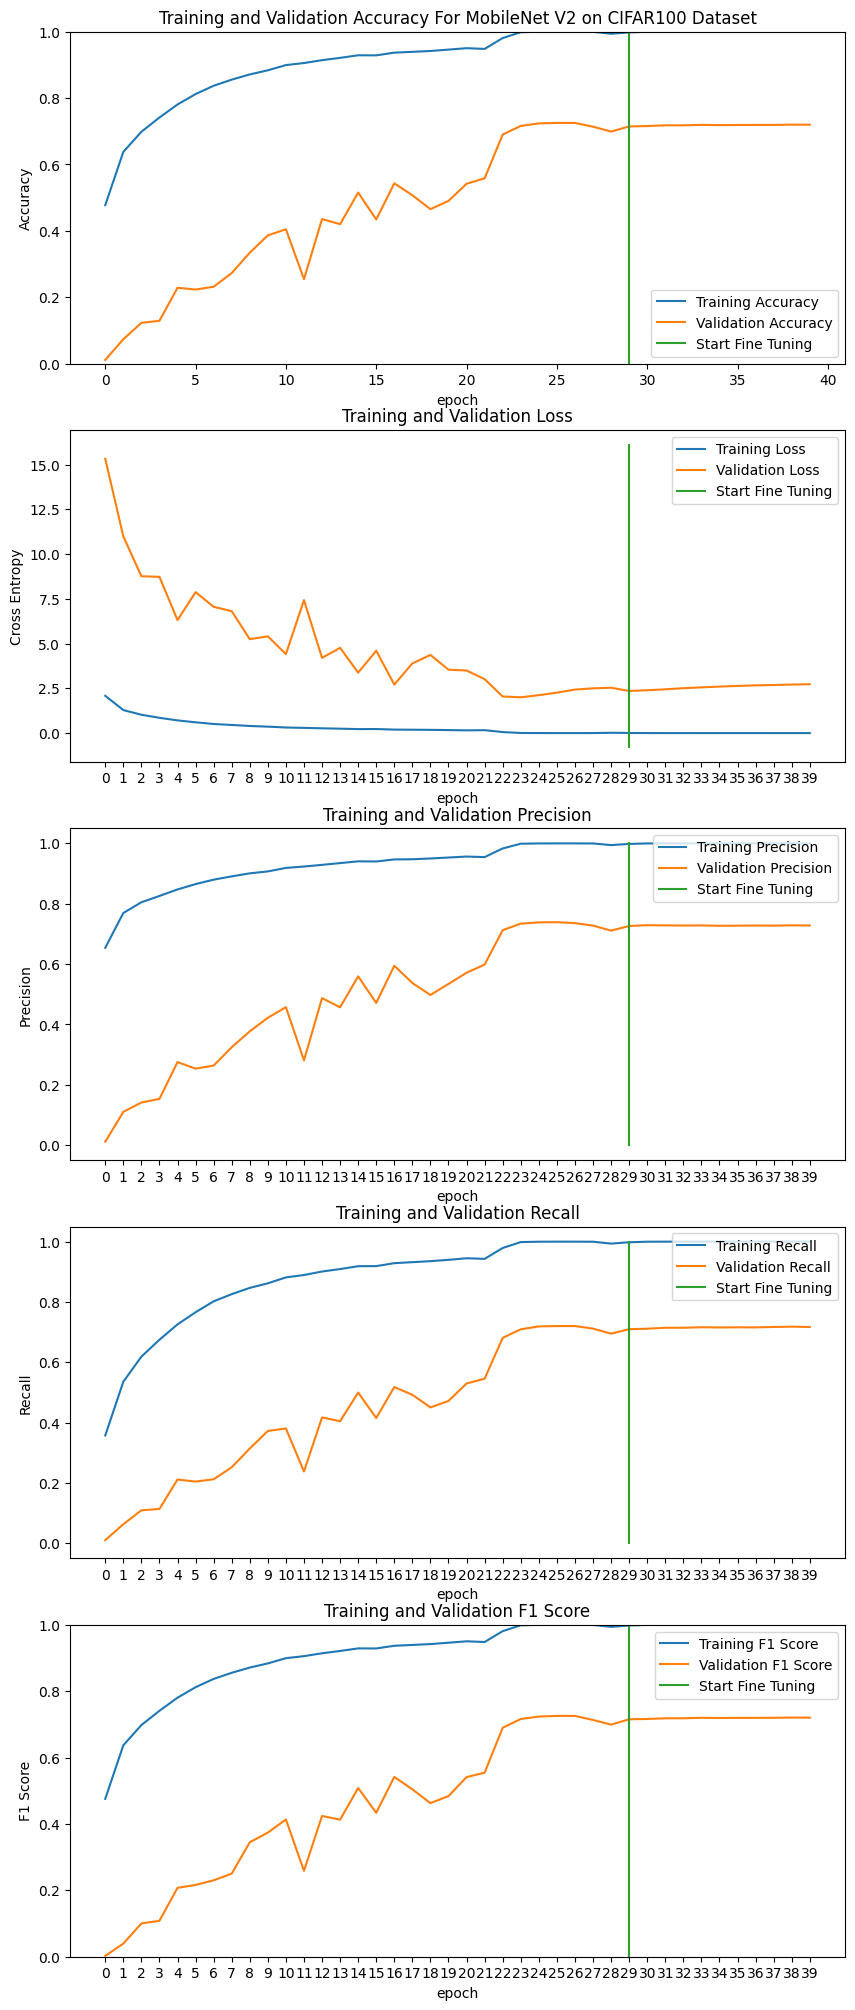

In [41]:
graph_accuracy_loss(history, total_epochs=total_epochs, fine_tune_history=fine_tune_history, initial_epochs=training_epochs)

## Step 4: Evaluate Final Model on Test Dataset

In [42]:
# Show the accuracy, precison, recall, and f1 score of our MobileNet V2 model
# on the CIFAR100 test images
loss, accuracy, precision, recall, f1_score = model.evaluate(test_dataset)

print("Test Accuracy: " + str(accuracy))
print("Test Precision: " + str(precision))
print("Test Recall: " + str(recall))
print("Test F1 Score: " + str(f1_score))

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7204 - f1_score: 0.7199 - loss: 2.6109 - precision: 0.7296 - recall: 0.7184
Test Accuracy: 0.7247999906539917
Test Precision: 0.7232000231742859
Test Recall: 0.7349593639373779
Test F1 Score: 0.724367082118988


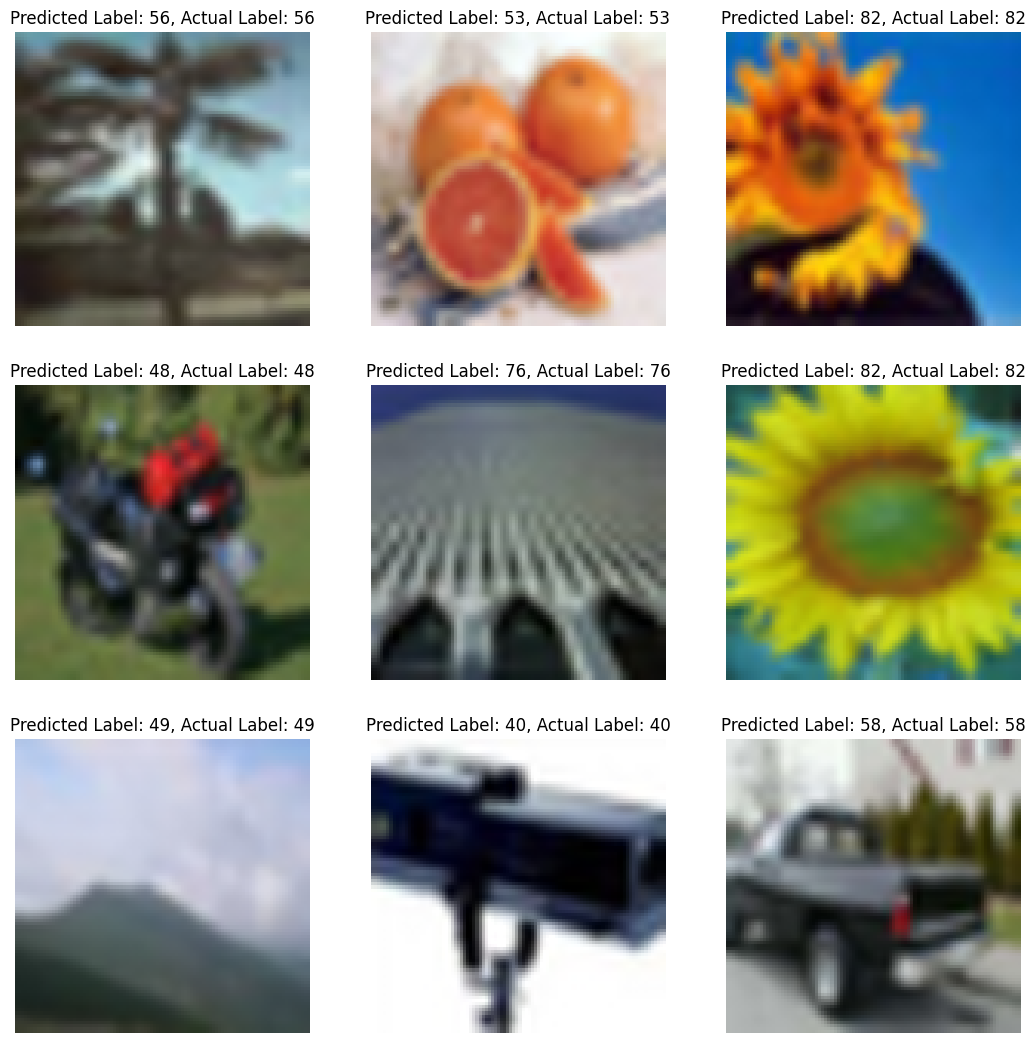

In [43]:
# Get some example images from the CIFAR100 test dataset to show MobileNet's predicted label
# next to their actual label
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
# Show 9 images from the CIFAR100 test dataset
plt.figure(figsize=(13, 13))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i])
  plt.title("Predicted Label: " + str(np.argmax(predictions[i])) + ", Actual Label: " + str(np.argmax(label_batch[i])))
  plt.axis("off")